# ITF Demo Jupyter Notebook - Implementing IE.L.ITF.1.2.1 Analog Receiver Integration and other tests using Tango Device Proxies 

This notebook implements some of the test cases for IE.L.ITF.1.2.1 Analog Receiver Integration and other tests including generating a signal from the AWG (arbitrary waveform generator) through to the spectrum analyser via several other pieces of test equipment.

Tango devices created for test equipment in the ITF by the VIOLA team that will be used include:
<ul>
  <li>AWG5208 (Arbitrary Waveform Generator)</li>
  <li>NCD R8xPL (Switch Relay)</li>
  <li>2SP6T (Switch Matrix)</li>
   <li>RC4DAT-6G-95 (Programmable Attenuators)</li>
  <li>RSA5103B (Spectrum Analyser)</li>
</ul>



In [1]:
import configuration  # # Python packages for configuration capture on the cluster
import display

charts = configuration.get_charts()
pods = configuration.get_pods()
tango_config = configuration.get_tango_config()

print("CHARTS")
display.as_json_tree(charts)
print("\nPODS")
display.as_json_tree(pods)
print("\nTANGO CONFIGURATION")
display.as_json_tree(tango_config)

ModuleNotFoundError: No module named 'configuration'
(For more detailed information type: python_error)


### Capture start time

In [2]:
log_start = display.utc_now()
print(log_start)

2023-09-13T01:56:19.624Z


### Initialise Device Proxies

Defined here the ```DeviceProxy``` objects to the Tango Devices running in the ITF cluster. These objects are what actually allow the interaction with the devices and send commands and queries to the hardware. This is running in an ITango kernel which provides many Tango specific features.

To turn these devices ```ON```, set the attribute ```adminMode = 0```.

In [17]:
awg = DeviceProxy("low-itf/awg/1")  # Arbritrary Waveform Generator (AWG5208)
progattenuator1 = DeviceProxy(
    "low-itf/progattenuator/1"
)  # Programmable Attenuator (RC4DAT-6G-95)
relay = DeviceProxy("low-itf/relay/1")  # Switch Relay (NCD R8xPL)
sp6t = DeviceProxy("low-itf/sp6t/1")  # Switch Matrix (RC-2SP6T-A18)
spectana = DeviceProxy("low-itf/spectana/1")  # Spectrum Analyser (RSA5103B)

In [15]:
awg.adminMode = 1
progattenuator1.adminMode = 1
relay.adminMode = 1
sp6t.adminMode = 1
spectana.adminMode = 1

In [13]:
awg.adminMode = 0
progattenuator1.adminMode = 0
relay.adminMode = 0
sp6t.adminMode = 0
spectana.adminMode = 1

In [18]:
# Display and check the device status
print(
    f"AWG: {awg.state().name}\nPROGATTENUATOR1: {progattenuator1.state().name}\nRELAY: {relay.state().name}\n2SP6T: {sp6t.state().name}\nSPECTANA: {spectana.state().name}"
)

AWG: DISABLE
PROGATTENUATOR1: DISABLE
RELAY: DISABLE
2SP6T: DISABLE
SPECTANA: DISABLE


### Configure the programmable attenuator on CH1

In [7]:
progattenuator1.channel_1 = 2.5

In [8]:
progattenuator1.channel_1

2.5

### Set RF switch to CH1

In [9]:
sp6t.switch_a = 1

### Configure the spectrum analyser (RSA5103B)

In [10]:
# Window to be captured

start_freq = 10e6
stop_freq = 500e6
ref_lev = -30.0

spectana.frequency_start = start_freq
spectana.frequency_stop = stop_freq
spectana.vbw_enabled = True
spectana.vbw = 10000

spectana.autoattenuation = False
spectana.attenuation = 0.0
spectana.reference_level = ref_lev

spectana.preamp_enabled = True

### Show the spectrum analyser trace

In [11]:
import numpy as np

x_ticks = np.linspace(start_freq, stop_freq, len(spectana.trace1))

Text(0, 0.5, 'Amplitude (dBm)')

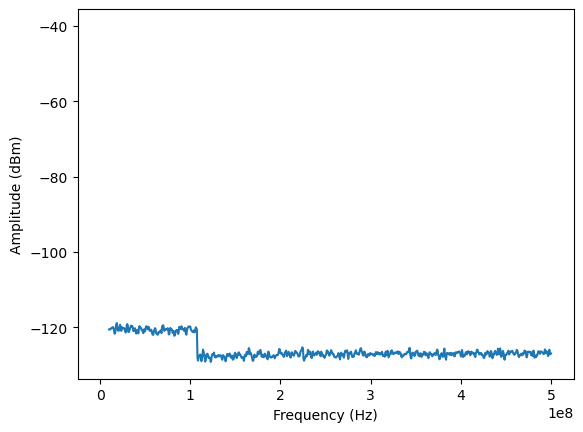

In [12]:
from matplotlib import pyplot as plt

plt.plot(x_ticks, spectana.trace1, -40)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dBm)")

### Turn on CH1 noise

In [13]:
relay.Relay1 = True

### Show the spectrum analyser trace

Text(0, 0.5, 'Amplitude (dBm)')

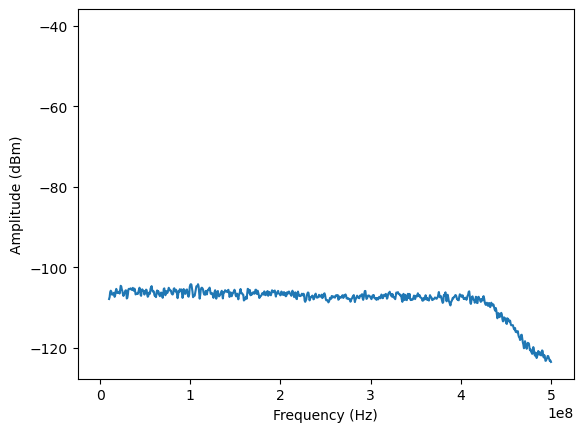

In [14]:
from matplotlib import pyplot as plt

plt.plot(x_ticks, spectana.trace1, -40)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dBm)")

### Turn off CH1 noise

In [15]:
relay.Relay1 = False

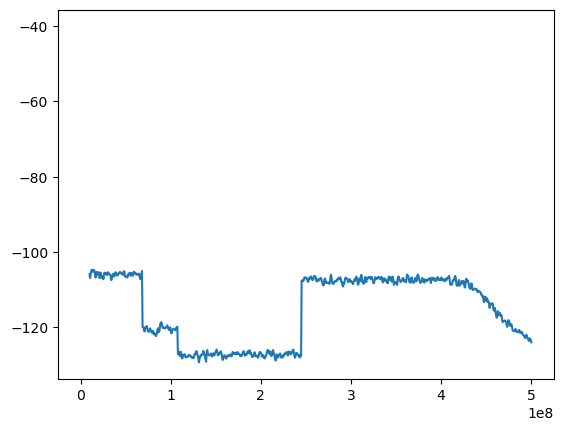

In [16]:
plt.plot(x_ticks, spectana.trace1, -40)

### Produce sine waves on channels 1 of the AWG

The arbritrary waveform generator in the ITF is the input to the sky signal generator. This is the 

In [17]:
# Set up variable arguments
mode = "FGEN"
waveform = "SINE"
frequency_Hz = 132e6
power_dB = 0

In [18]:
# Set device attributes
awg.instrument_mode = mode
awg.channel1_type = waveform
awg.channel1_freq = frequency_Hz
awg.channel1_amplitude_power = power_dB

In [19]:
print(
    f"The characteristics on the waveform are as follows:\n\nMODE: {awg.instrument_mode}\nTYPE: {awg.channel1_type}\nFREQUENCY (Hz): {awg.channel1_freq}\nPOWER (dBm): {awg.channel1_amplitude_power}"
)

The characteristics on the waveform are as follows:

MODE: FGEN
TYPE: SINE
FREQUENCY (Hz): 132000000.0
POWER (dBm): 1.7763568394e-15


In [20]:
# Play the signal through the channel 1 output
awg.channel1_output_state = True
awg.Play()

### Acquire the signal on the RSA5103B

Text(0, 0.5, 'Amplitude (dBm)')

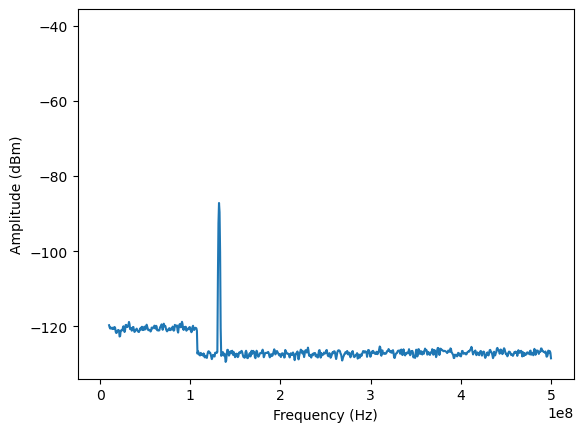

In [21]:
from matplotlib import pyplot as plt

plt.plot(x_ticks, spectana.trace1, -40)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dBm)")

### Turn off AWG

In [22]:
awg.Stop()
awg.channel1_output_state = False

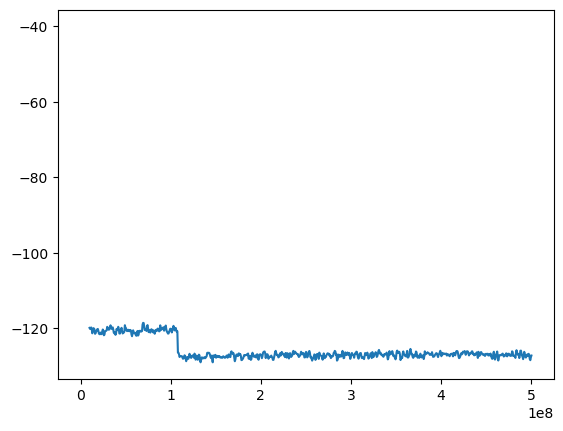

In [23]:
plt.plot(x_ticks, spectana.trace1, -40)

# PaSD Curtin Scripts

### Turn on the FEMs in SMART box 1

In [33]:
%run ../pasd_control/FNPCPDocON.py --PDoC=1
%run ../pasd_control/FNSCSetStatus.py --SB=1


FNPC Turn on PDoC 1
->:65 06 0023 3C00 36 | <-:65 06 0023 3C00 36

FNSC(01) Set STATUS_OK
->:01 06 0015 0000 E4 | <-:01 86 0B 6E
->:01 03 0015 0001 E6 | <-:01 83 0B 71


In [34]:
%run ../pasd_control/FNSCFEMOn.py --SB=1 --FEM=1
# %run ../pasd_control/FNSCFEMOn.py --SB=1 --FEM=2


FNSC(01) Turn on FEM 1
->:01 06 0023 3C00 9A | <-:01 06 0015 0000 E4


In [35]:
%run ../pasd_control/FNSCGetValues.py --SB=1


FNSC(01) read 48VIn
->:01 03 0010 0001 EB | <-:01 06 0023 3C00 9A

FNSC(01) read PSU Out
->:01 03 0011 0001 EA | <-:01 83 0B 71

FNSC(01) Read PSU Temp
->:01 03 0012 0001 E9 | <-:01 03 02 09B5 3C (24.85C)

FNSC(01) Read AMB Temp and Four Temps, all in FEM Package enclosure
->:01 03 0014 0001 E7 | <-:01 03 02 0829 C9 (20.89C)
->:01 03 0017 0004 E1 | <-:01 03 08 0829 080E 081F 0833 4B (20.89C, 20.62C, 20.79C, 20.99C)

FNSC(01) Read 12 FEM Currents
->:01 03 002F 000C C1 | <-:01 03 18 0142 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 0000 A1
            (322mA, 0mA, 0mA, 0mA, 0mA, 0mA, 0mA, 0mA, 0mA, 0mA, 0mA, 0mA)


### Turn on Channel 1 noise

In [40]:
relay.Relay1 = True

Text(0, 0.5, 'Amplitude (dB)')

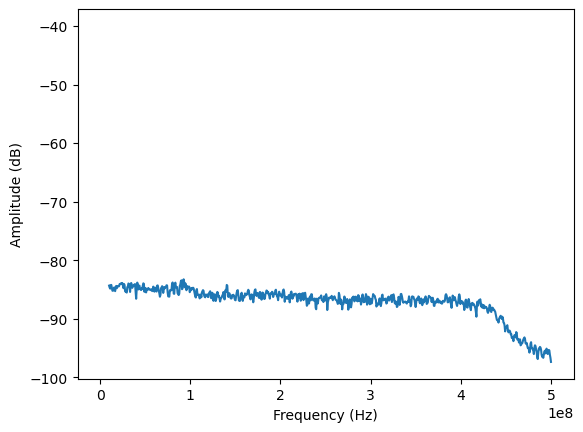

In [28]:
plt.plot(x_ticks, spectana.trace1, -40)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")

### Turn off Channel 1 noise

In [41]:
relay.Relay1 = False

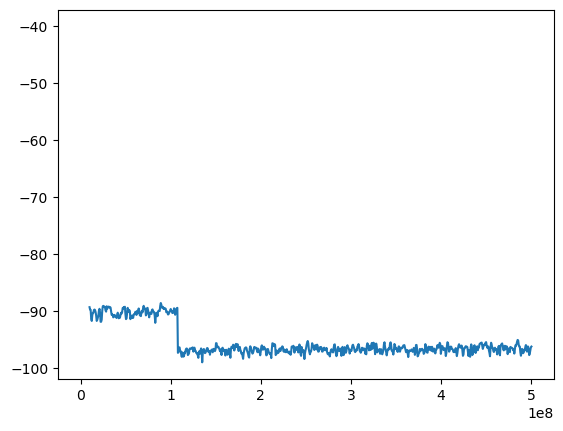

In [30]:
plt.plot(x_ticks, spectana.trace1, -40)

### Turn on AWG carrier

In [31]:
awg.Play()
awg.channel1_output_state = True

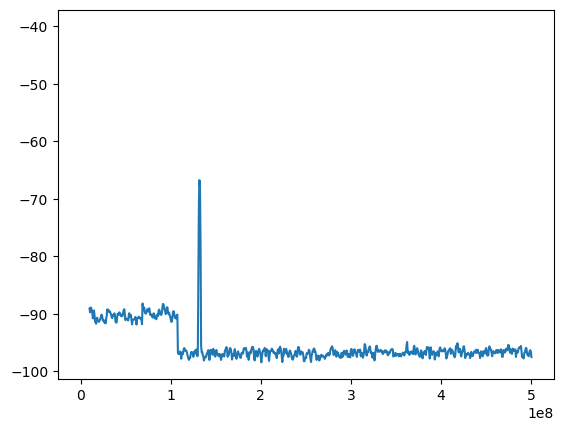

In [32]:
plt.plot(x_ticks, spectana.trace1, -40)

### Turn off AWG carrier

In [33]:
awg.Stop()
awg.channel1_output_state = False

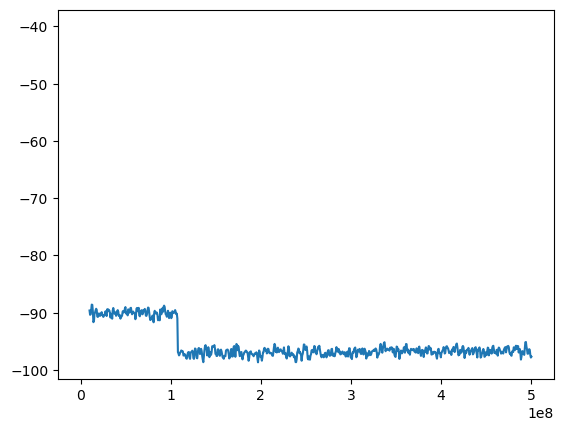

In [34]:
plt.plot(x_ticks, spectana.trace1, -40)

## TPM control
The TPM and PreAdu contol including the setting of PreADU attenuation and monitoring of TPM diagnostics will be 
done using SKA-LAB

### Shutdown steps

In [42]:
%run ../pasd_control/FNSCFEMOff.py --SB=1 --FEM=1
# %run ../pasd_control/FNSCFEMOff.py --SB=1 --FEM=2


FNSC(01) Turn off FEM 1
->:01 06 0023 2800 AE | <-:01 06 0023 2800 AE


In [43]:
%run ../pasd_control/FNSCGetValues.py --SB=1


FNSC(01) read 48VIn
->:01 03 0010 0001 EB | <-:01 03 02 12FF E9 (48.63V)

FNSC(01) read PSU Out
->:01 03 0011 0001 EA | <-:01 03 02 01DB 1E (4.75V)

FNSC(01) Read PSU Temp
->:01 03 0012 0001 E9 | <-:01 03 02 09BF 32 (24.95C)

FNSC(01) Read AMB Temp and Four Temps, all in FEM Package enclosure
->:01 03 0014 0001 E7 | <-:01 03 02 083B B7 (21.07C)
->:01 03 0017 0004 E1 | <-:01 03 08 082E 0811 082E 0838 2F (20.94C, 20.65C, 20.94C, 21.04C)

FNSC(01) Read 12 FEM Currents
->:01 03 002F 000C C1 | <-:01 03 18 0000 0010 0020 0010 0030 0010 0010 0000 0020 0020 0020 0010 E4
            (0mA, 16mA, 32mA, 16mA, 48mA, 16mA, 16mA, 0mA, 32mA, 32mA, 32mA, 16mA)


In [44]:
%run ../pasd_control/FNPCPDocOFF.py --PDoC=1


FNPC Turn off PDoC 1
->:65 06 0023 2800 4A | <-:65 06 0023 2800 4A


In [45]:
awg.adminMode = 1
progattenuator1.adminMode = 1
relay.adminMode = 1
sp6t.adminMode = 1
spectana.adminMode = 1

In [46]:
# Display and check the device status
print(
    f"AWG: {awg.state().name}\nPROGATTENUATOR1: {progattenuator1.state().name}\nRELAY: {relay.state().name}\n2SP6T: {sp6t.state().name}\nSPECTANA: {spectana.state().name}"
)

AWG: DISABLE
PROGATTENUATOR1: DISABLE
RELAY: DISABLE
2SP6T: DISABLE
SPECTANA: DISABLE


### Capture end time and link to logs

In [30]:
log_end = display.utc_now()
display.log_link(log_start, log_end)

## Execution logs
[Kibana: 2023-09-13T01:56:19.624Z to 2023-09-13T02:53:24.172Z](https://k8s.stfc.skao.int/kibana/app/dashboards#/view/c59d04e0-4221-11ee-968a-b75fa630781d?_g=(time:(from:'2023-09-13T01:56:19.624Z',to:'2023-09-13T02:53:24.172Z')))